# Neural Network Dev Notebook

This notebook is for development of a suitable neural network for training on the training set. Here, I use the dev set and tune hyperparameters and model structure for best performance. 

In [186]:
import keras
import glob
import os
from PIL import Image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Lambda
from keras import backend as K
from keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Load the dev set and images

Creates a dict relating artist MBIDs to spectrogram images, represented as 128x128x1 arrays of floats. Also load the previously saved database of artist relationships.

For now, we only load the first track we have on file for each artist, even if we have more. This can be changed later.

In [187]:
images = defaultdict(list)

for path in tqdm_notebook(glob.glob('tracks/**/*.png', recursive=True)):
    mbid = os.path.basename(path).rsplit('-', 1)[0]
    img = np.array(Image.open(path).convert('L')) / 255
    img = np.reshape(img, img.shape + (1,))
    images[mbid].append(img)
    
raw_dataset = pd.read_hdf('dataset/dev_alt.hd5', key='artists')

In [188]:
display('Artists in images: {}'.format(len(images)))
display('Dataset length: {}'.format(len(raw_dataset)))

'Artists in images: 9484'

'Dataset length: 9496'

## Create dataset relating image references to values

Previously, we had the large raw dataset which is of the form `raw_dataset[artistA][artistB]=similarity`. Here, we create X and Y arrays, with the X array being a list of two arrays, each containing references to one of the spectrogram images that was loaded for a given artist. The Y array is a list containing the similarity scores for the corresponding two artists.

In [189]:
X_1 = list()
X_2 = list()
Y = list()

for index, value in tqdm_notebook(raw_dataset.iteritems(), total = len(raw_dataset)):
    X_1.append(images[index[0]][0])
    X_2.append(images[index[1]][0])
    Y.append(value)
    
X_1_train, X_1_test, X_2_train, X_2_test, Y_train, Y_test = train_test_split(X_1, X_2, Y, test_size=0.02, random_state = 1)
display('Training set size: {}'.format(len(Y_train)))
display('Test set size: {}'.format(len(Y_test)))
X_train = [X_1_train, X_2_train]
X_test = [X_1_test, X_2_test]

'Training set size: 9306'

'Test set size: 190'

## Define Keras model

This defines a siamese network, which trains the same model with the same parameters and applies it to both images. The output of this shared vector is a fully-connected network with 128 neurons, for each image. The L1 distance between these two networks is then taken and the resulting 128 length vector is fed into a final sigmoid function.

In [191]:
def L1_distance(x):
    return K.abs(x[0] - x[1])

def L1_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1

def create_base_network(input_shape):
    input = Input(shape = input_shape)
    x = ZeroPadding2D()(input) # 129x129x1
    x = Conv2D(8,(7,7),activation='tanh')(x) # 62x62x8
    x = MaxPooling2D()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(16,(7,7),activation='tanh')(x) # 29x29x16
    x = MaxPooling2D()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(32,(7,7),activation='tanh')(x) # 12x12x32
    x = MaxPooling2D()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(64,(7,7),activation='tanh')(x) # 4x4x64
    x = MaxPooling2D()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(128,(5,5),activation='tanh')(x) # 1x1x128
    x = Flatten()(x)
    x = Dense(128, activation='tanh')(x) # FC 128
    return Model(input, x)
    
def create_model():
    input_shape = (128,128,1)

    siamese_net = create_base_network(input_shape)

    input_a = Input(shape = input_shape)
    input_b = Input(shape = input_shape)

    process_a = siamese_net(input_a)
    process_b = siamese_net(input_b)

    distance = Lambda(L1_distance, output_shape = L1_dist_output_shape)([process_a, process_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model([input_a, input_b], output)

    adam = Adam()
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    
    return model

model = create_model()

## Train the neural network

Define a function to randomly sample batches from the X and Y datasets, then train our model on these minibatches. Train over a certain number of iterations, updating a live plot with train and test errors.

<IPython.core.display.Javascript object>


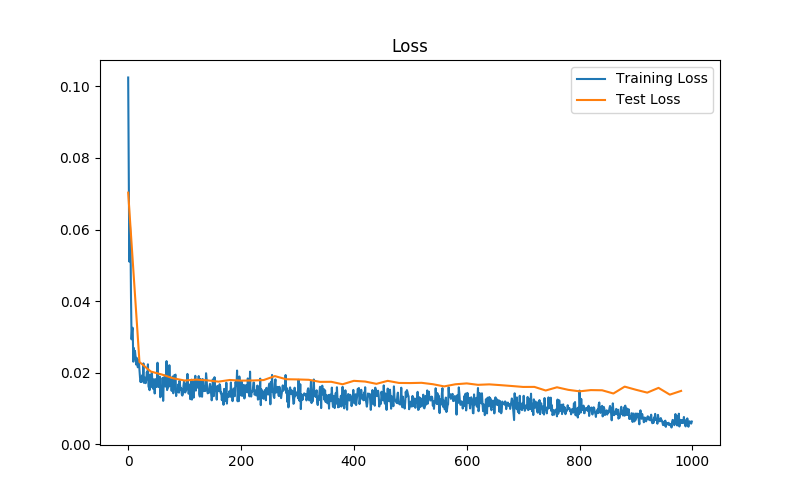

In [215]:
%matplotlib notebook

batch_size = 1000
n_iters = 1000
test_loss_every = 20

def get_batch(batch_size, train = True):
    if train:
        X = X_train
        Y = Y_train
    else:
        X = X_test
        Y = Y_test
    indices = np.random.choice(len(Y), size = batch_size)
    X_batch = [list(), list()]
    X_batch[0] = [X[0][i] for i in indices]
    X_batch[1] = [X[1][i] for i in indices]
    Y_batch = [Y[i] for i in indices]
    return X_batch, Y_batch

train_error = list()
test_error = list()

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8,5)
line_train, = ax1.plot(train_error)
line_test, = ax1.plot(np.array(range(len(test_error))) * 20,test_error)
ax1.set_title("Loss")
ax1.legend([line_train, line_test], ['Training Loss', 'Test Loss'])
plt.ion()

fig.show()
fig.canvas.draw()

t = tnrange(n_iters, desc='[Iteration 0]', leave=True, ncols='800px')
for i in t:
    (inputs, targets) = get_batch(batch_size)
    train_loss = model.train_on_batch(inputs, targets)
    train_error.append(train_loss)
    if i % test_loss_every == 0:
        test_loss = model.evaluate(X_test, Y_test, verbose=0)
        test_error.append(test_loss)
    t.set_description("[Iteration {}, Loss = {:.10f}]".format(i + 1, train_loss))
    t.refresh()
    ax1.clear()
    line_train, = ax1.plot(train_error)
    line_test, = ax1.plot(np.array(range(len(test_error))) * 20, test_error)
    ax1.set_title("Loss")
    ax1.legend([line_train, line_test], ['Training Loss', 'Test Loss'])
    fig.canvas.draw()

### Save the trained model

In [100]:
model.save("model/saved_full.hd5")

## Random checking below

In [101]:
display(model.evaluate(X_test, Y_test))

18614/18614 [==============================] - 8s 444us/step


0.0030250266137605637

In [185]:
X_sample, Y_sample = get_batch(1, train=False)
display(model.predict(X_sample))
display(Y_sample)

array([[0.11584488]], dtype=float32)

[0.05626470281994131]

In [152]:
X_tmp, Y_tmp = get_batch(1000)
model.evaluate(X_tmp, Y_tmp)

1000/1000 [==============================] - 1s 526us/step


0.0026132430359721184